# Geospatial Analysis of Crash Cases in Philadelphia from 2010 - 2021

This data is aggregated by Police District.

In [584]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas

In [585]:
# Spatial Plot
philly_map = geopandas.read_file("./Boundaries_District/Boundaries_District.shp")
philly_map_2 = philly_map.copy()

# Crash Dataset
df = pd.read_csv("./APAC_2023_Datasets/Crashes/crash_info_general.csv")

#commerical vehicles crash dataset
df_2 = pd.read_csv("./APAC_2023_Datasets/Crashes/crash_info_commericial_vehicles.csv")

/var/folders/5n/7955wqx52_s2p0fymgbx_vsh0000gn/T/ipykernel_81044/3952697139.py:6: DtypeWarning: Columns (97,98,99) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/Users/pongyizhen/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Y2S2_Citadel comps/APAC_2023_Datasets/Crashes/crash_info_general.csv")


In [586]:
#drop all rows without GVWR first
df_2 = df_2.dropna(subset=['GVWR'])


In [587]:
#add binary column for heavy COMMERCIAL vehicles
df_2['heavy_commercial_vehicle'] = df_2['GVWR'].apply(lambda x: 1 if x > '26001.0' else 0)
df_2.head()

#heavy duty is >26, 001 lbs from: https://afdc.energy.gov/data/10380#:~:text=GVWR%20includes%20total%20vehicle%20weight,emissions%20and%20fuel%20economy%20certification.

,CRN,AXLE_CNT,CARGO_BD_TYPE,CARRIER_ADDR_1,CARRIER_ADDR_2,CARRIER_ADDR_CITY,CARRIER_ADDR_STATE,CARRIER_ADDR_ZIP,CARRIER_NM,CARRIER_TEL,...,HAZMAT_REL_IND2,HAZMAT_REL_IND3,HAZMAT_REL_IND4,ICC_NUM,OSIZE_LOAD_IND,PUC_NUM,UNIT_NUM,USDOT_NUM,VEH_CONFIG_CD,heavy_commercial_vehicle
0,2018011941,99.0,4,SWEDE RD JOHNSON HIGHWA,NaN,NORRISTOWN,PA,19021,PENNDOT,6.102752e+09,...,NaN,NaN,NaN,NaN,N,NaN,2,09722069,9,1
1,2018016805,2.0,1,625 S FIFTH AVE,NaN,LEBANON,PA,17042,NEW PENN MOTOR EXPRESS,8.567868e+09,...,NaN,NaN,NaN,NaN,N,NaN,3,00010670,8,1
2,2018019901,2.0,8,7700 STATE ROAD,NaN,PHILADELPHIA,PA,19136,YELLOWBIRD TRANSPORTATION,2.152891e+09,...,NaN,NaN,NaN,NaN,N,NaN,1,00273447,11,1
3,2018029902,99.0,9,100 BELMONT AVE,NaN,BALA CYNWYD,PA,19004,BALA MOTORSPORTS,1.000000e+10,...,NaN,NaN,NaN,NaN,N,NaN,2,NaN,5,1
4,2018030927,2.0,8,1234 MARKET STREET,NaN,PHILADELPHIA,PA,19107,SEPTA,3.024203e+09,...,NaN,NaN,NaN,NaN,N,NaN,2,NaN,11,1


In [588]:
#using df_2 we filter all the rows with heavy commerical vehicles
df_2 = df_2[df_2['heavy_commercial_vehicle'] == 1]

#remove any duplicate CRN values
df_2 = df_2.drop_duplicates(subset=['CRN'], keep='first')

In [589]:
#any combine onto df based on CRN, retaining all rows in df
merged_df = df.merge(df_2, on='CRN', how='left')


In [590]:
#fill all the NA rows in heavy_commerical vehicle with 0
merged_df['heavy_commercial_vehicle'] = merged_df['heavy_commercial_vehicle'].fillna(0)

In [591]:
#add binary column for heavy vehicles
merged_df['heavy_vehicles'] = (merged_df['BUS_COUNT'] + merged_df['HEAVY_TRUCK_COUNT'] + merged_df['heavy_commercial_vehicle']).apply(lambda x: 1 if x > 0 else 0)

In [592]:
# Create GeoSpatial DataFrame
crashes_coords = geopandas.GeoDataFrame(
    merged_df,
    geometry=geopandas.points_from_xy(df['DEC_LONG'], df['DEC_LAT'])
)

In [593]:
# Map to district
crashes_coords['DISTRICT_'] = ''
for idx in range(philly_map.shape[0]):
    pip = crashes_coords.within(philly_map.loc[idx, 'geometry'])
    if pip.sum() > 0:
        crashes_coords.loc[pip, 'DISTRICT_'] = philly_map.loc[idx, 'DISTRICT_']
  

In [594]:
#Filter out invalid cases that do not fall within the districts
crashes_coords = crashes_coords[crashes_coords['DISTRICT_'] != '']


In [595]:
#group by district and count, before filtering for heavy vehicles
stats_before_filter = crashes_coords.groupby(['DISTRICT_'])[['CRN']].count()

print(stats_before_filter)

             CRN
DISTRICT_       
1           3333
2           6270
3           6475
5           1999
6           6995
7           4272
8           7706
9           4967
12          8005
14          5866
15         12130
16          8840
17          2537
18          7567
19          4887
22          6135
24          6893
25          7485
26          5183
35          7089
39          6890
77            44


In [596]:
# Filter cases with heavy vehicles
crashes_coords = crashes_coords[crashes_coords['heavy_vehicles'] == 1]

In [597]:
#Group by district and count
stats = crashes_coords.groupby(['DISTRICT_'])[['CRN']].count()

stats = stats.sort_values(by="CRN", ascending=False)
print(stats)

           CRN
DISTRICT_     
15         781
6          638
16         604
12         572
8          534
3          493
24         481
25         434
39         404
18         371
35         344
9          329
26         328
22         326
14         252
19         252
2          242
1          237
17         175
7          152
5           96
77           4


In [598]:
stats_ratio = stats.merge(stats_before_filter, on = 'DISTRICT_')
stats_ratio = stats_ratio.reset_index()
stats_ratio['ratio'] = stats_ratio['CRN_x']/ stats_ratio['CRN_y']


stats_ratio = stats_ratio.sort_values(by="ratio", ascending=False)
print(stats_ratio)

    DISTRICT_  CRN_x  CRN_y     ratio
1           6    638   6995  0.091208
21         77      4     44  0.090909
5           3    493   6475  0.076139
3          12    572   8005  0.071455
17          1    237   3333  0.071107
6          24    481   6893  0.069781
4           8    534   7706  0.069297
18         17    175   2537  0.068979
2          16    604   8840  0.068326
11          9    329   4967  0.066237
0          15    781  12130  0.064386
12         26    328   5183  0.063284
8          39    404   6890  0.058636
7          25    434   7485  0.057983
13         22    326   6135  0.053138
15         19    252   4887  0.051565
9          18    371   7567  0.049029
10         35    344   7089  0.048526
20          5     96   1999  0.048024
14         14    252   5866  0.042959
16          2    242   6270  0.038596
19          7    152   4272  0.035581


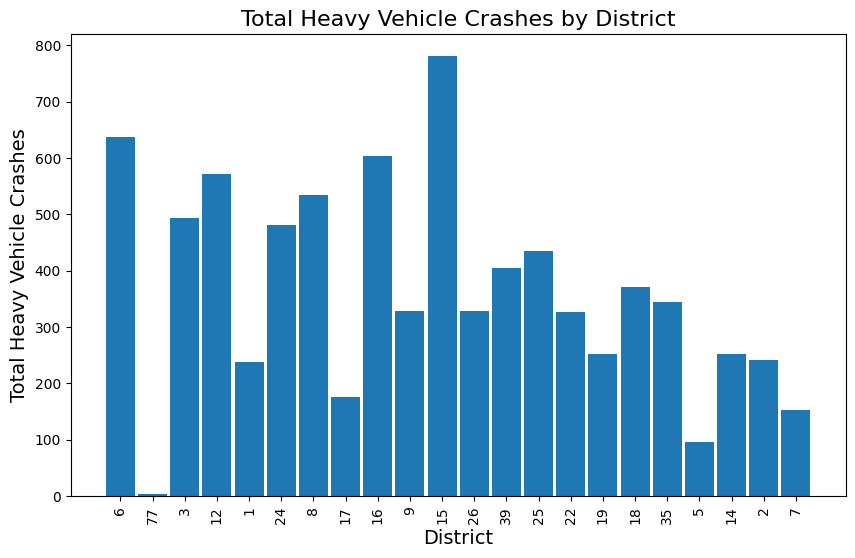

In [599]:
# create a figure and axis object
fig, ax = plt.subplots(figsize=(10,6))
stats_ratio_copy = stats_ratio.copy()
stats_ratio_copy['DISTRICT_'] = stats_ratio_copy['DISTRICT_'].astype(str)
#stats_ratio = stats_ratio.sort_values(by="CRN_x", ascending=False)

# create a bar plot with district on x-axis and CRN_x on y-axis
bar_plot = ax.bar(stats_ratio_copy['DISTRICT_'], stats_ratio_copy['CRN_x'], width=0.9)

# set plot title and axis labels
ax.set_title('Total Heavy Vehicle Crashes by District', fontsize=16)
ax.set_xlabel('District', fontsize=14)
ax.set_ylabel('Total Heavy Vehicle Crashes', fontsize=14)

# rotate x-axis labels for better readability
plt.xticks(rotation=90)

# display the plot
plt.show()

In [600]:
# Merge count into map
map_and_stats = philly_map.merge(stats, on='DISTRICT_')

(-75.2965363338824, -74.939522217298, 39.853475402027584, 40.15148900478962)

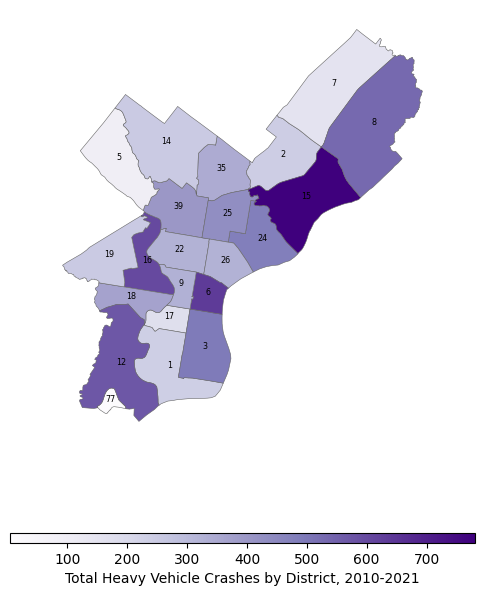

In [601]:
fig, ax = plt.subplots(1, figsize=(12,8))
plt.xticks(rotation=90)
map_and_stats.plot(
    column='CRN',
    cmap='Purples',
    linewidth=0.4,
    ax=ax,
    edgecolor='.4',
    legend=True,
    legend_kwds={
        'label': "Total Heavy Vehicle Crashes by District, 2010-2021",
        'orientation': 'horizontal',
        'shrink': 0.5,
        'aspect': 50
    }
)
map_and_stats.apply(lambda x: ax.annotate(text=x['DIST_NUM'], xy=x.geometry.centroid.coords[0], ha='center', fontsize='xx-small'), axis=1)
ax.axis('off')

In [602]:
# Merge count into map if we using stats ratio
map_and_stats2 = philly_map_2.merge(stats_ratio, on='DISTRICT_')

(-75.2965363338824, -74.939522217298, 39.853475402027584, 40.15148900478962)

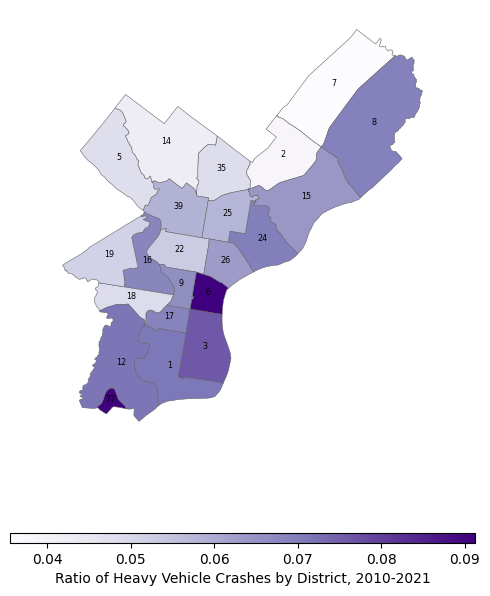

In [603]:
fig, ax = plt.subplots(1, figsize=(12,8))
plt.xticks(rotation=90)
map_and_stats2.plot(
    column='ratio',
    cmap='Purples',
    linewidth=0.4,
    ax=ax,
    edgecolor='.4',
    legend=True,
    legend_kwds={
        'label': "Ratio of Heavy Vehicle Crashes by District, 2010-2021",
        'orientation': 'horizontal',
        'shrink': 0.5,
        'aspect': 50
    }
)
map_and_stats.apply(lambda x: ax.annotate(text=x['DIST_NUM'], xy=x.geometry.centroid.coords[0], ha='center', fontsize='xx-small'), axis=1)
ax.axis('off')